# タイムスタンプと、データも同時に取得する

## おまじない

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import re
from PIL import Image, ImageOps
import matplotlib.patches as patches

In [2]:
from PIL import Image
import sys

import pyocr
import pyocr.builders

tools = pyocr.get_available_tools()
if len(tools) == 0:
    print("No OCR tool found")
    sys.exit(1)
# The tools are returned in the recommended order of usage
tool = tools[0]
print("Will use tool '%s'" % (tool.get_name()))
# Ex: Will use tool 'libtesseract'

langs = tool.get_available_languages()
print("Available languages: %s" % ", ".join(langs))
lang = langs[0]
print("Will use lang '%s'" % (lang))
# Ex: Will use lang 'fra'
# Note that languages are NOT sorted in any way. Please refer
# to the system locale settings for the default language
# to use.

Will use tool 'Tesseract (sh)'
Available languages: afr, amh, ara, asm, aze, aze_cyrl, bel, ben, bod, bos, bre, bul, cat, ceb, ces, chi_sim, chi_sim_vert, chi_tra, chi_tra_vert, chr, cos, cym, dan, deu, div, dzo, ell, eng, enm, epo, est, eus, fao, fas, fil, fin, fra, frk, frm, fry, gla, gle, glg, grc, guj, hat, heb, hin, hrv, hun, hye, iku, ind, isl, ita, ita_old, jav, jpn, jpn_vert, kan, kat, kat_old, kaz, khm, kir, kmr, kor, kor_vert, lao, lat, lav, lit, ltz, mal, mar, mkd, mlt, mon, mri, msa, mya, nep, nld, nor, oci, ori, osd, pan, pol, por, pus, que, ron, rus, san, script/Arabic, script/Armenian, script/Bengali, script/Canadian_Aboriginal, script/Cherokee, script/Cyrillic, script/Devanagari, script/Ethiopic, script/Fraktur, script/Georgian, script/Greek, script/Gujarati, script/Gurmukhi, script/HanS, script/HanS_vert, script/HanT, script/HanT_vert, script/Hangul, script/Hangul_vert, script/Hebrew, script/Japanese, script/Japanese_vert, script/Kannada, script/Khmer, script/Lao, scri

In [3]:
# tiffが16bitだとocrが上手くいかない -> 8bitに変換する
def tiff_force_8bit(image, **kwargs):
    if image.format == 'TIFF' and image.mode == 'I;16':
        array = np.array(image)
        normalized = (array.astype(np.uint16) - array.min()) * 255.0 / (array.max() - array.min())
        image = Image.fromarray(normalized.astype(np.uint8))

    return image

#hhmmssをsecに変換する
def convert_hhmmss2sec(time_hhmmss) :
    time_hh = np.floor(time_hhmmss * 1e-4)
    time_mm = np.floor((time_hhmmss - time_hh * 1e4) * 1e-2)
    time_ss = time_hhmmss - time_hh * 1e4 - time_mm * 1e2
    return time_hh * 3600 + time_mm * 60 + time_ss

#file nameを連番に読み込むためのおまじない
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

## データのフォルダを指定する

In [6]:
#dirname = 'C:\\Jup\\190422_015428\\'
dirname = '/Users/keisuke/Dropbox/2021_36/20211221_134601 sns hbn 2-1 1hr-q 500pps 0-360deg 1s 3mW_nagashio'

filename ='*.tif'
filelist = sorted(glob.glob(os.path.join(dirname, filename)), key=natural_keys)
#print(filelist[0])

## 画像の解析個所を確認する

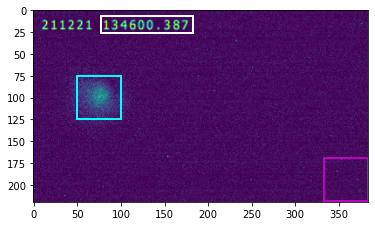

In [13]:
x_timestamp1 = 77
y_timestamp1 = 6
x_timestamp2 = 183
y_timestamp2 = 26
xsize_timestamp = x_timestamp2 - x_timestamp1
ysize_timestamp = y_timestamp2 - y_timestamp1

image = Image.open(filelist[0])
xmax, ymax = image.size
    
#image.show()
plt.imshow(image)
ax = plt.gca()

x1 = 50
y1 = 75
x2 = 100
y2 = 125

xsize = x2-x1
ysize = y2-y1
rect0 = patches.Rectangle((x_timestamp1, y_timestamp1),xsize_timestamp,ysize_timestamp, linewidth=2,edgecolor='white', fill = False)
rect1 = patches.Rectangle((x1, y1),xsize,ysize, linewidth=2,edgecolor='cyan', fill = False)
rect2 = patches.Rectangle((xmax-xsize-1, ymax-ysize-1),xsize,ysize, linewidth=2,edgecolor='m', fill = False)

ax.add_patch(rect0)
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

## データのよみとり

In [14]:
time_hhmmss_ndarray = np.zeros(len(filelist))
Values_ndarray = np.zeros(len(filelist))

pixelsize = abs((x2-x1+1) * (y2-y1+1) )

i = 0
for file in filelist:
    image = Image.open(file)
    Values = 0
    bg = 0

    for x in range(x1, x2, 1):
        for y in range(y1, y2, 1):
            Values += image.getpixel((x, y))
            bg += image.getpixel((xmax-x2 + x, ymax-y2 + y))
    Values_ndarray[i] = (Values-bg)/pixelsize

    res = tiff_force_8bit(image).crop((x_timestamp1, y_timestamp1, x_timestamp2, y_timestamp2))
    img_box = ImageOps.invert(res)
    txt = tool.image_to_string(img_box, lang='eng', builder=pyocr.builders.DigitBuilder(tesseract_layout=6))

    time_hhmmss_ndarray[i] = float(txt.replace(' ', '').replace('  ', ''))
    if i% (np.floor(len(filelist)/10))==0 : print(f'{np.floor(100 * i/len(filelist)):.0f} %')
    i+=1

0 %
9 %
19 %
29 %
39 %
49 %
58 %
68 %
78 %
88 %
98 %


In [15]:
df = pd.DataFrame(Values_ndarray)
df.columns = ['Values']
df['time_s'] = pd.DataFrame(convert_hhmmss2sec(time_hhmmss_ndarray)-convert_hhmmss2sec(time_hhmmss_ndarray[0]))
df.head(3)

,Values,time_s
0,9252.099962,0.000
1,9184.704344,1.010
2,9262.125336,2.024


##　データの確認

Text(0, 0.5, 'exposure time (s)')

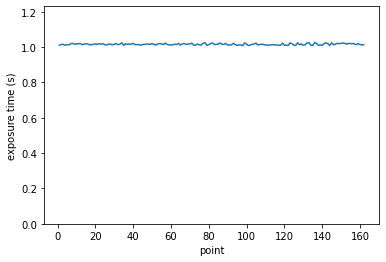

In [16]:
ax = df['time_s'].diff().plot(ylim=[0, df['time_s'].diff().max()*1.2])
ax.set_xlabel('point')
ax.set_ylabel('exposure time (s)')

## データのいったん保存

In [17]:
filename ='rawdata.csv'
outfile = os.path.join(dirname, filename)
df.to_csv(outfile, index = False)
df

,Values,time_s
0,9252.099962,0.000
1,9184.704344,1.010
2,9262.125336,2.024
3,9307.821607,3.039
4,9932.873510,4.049
...,...,...
158,11612.953479,160.463
159,11339.044983,161.483
160,11302.120723,162.497
161,11413.165705,163.509


# SHGを解析する

## 実験条件

In [27]:
speed_degs = 2.5 # degree/s, if it is pps, devide by 200
totalangle_theta = 360

## 実験データの読み込み

In [28]:
filename ='rawdata.csv'
filepath = os.path.join(dirname, filename)
df = pd.read_csv(filepath)
df

,Values,time_s
0,9252.099962,0.000
1,9184.704344,1.010
2,9262.125336,2.024
3,9307.821607,3.039
4,9932.873510,4.049
...,...,...
158,11612.953479,160.463
159,11339.044983,161.483
160,11302.120723,162.497
161,11413.165705,163.509


In [29]:
data = df['Values'].to_numpy()
time_s = df['time_s'].to_numpy()
time_i = np.arange(len(time_s))

In [30]:
pmax=np.argmax(np.append(0,np.diff(data))[0:20])
pmin=np.argmin(np.append(0,np.diff(data))[0:20])
point1 = pmax if (pmax < pmin) else pmin
point2 = pmax if (pmax > pmin) else pmin

## データを確認してジャンプを探す推測する

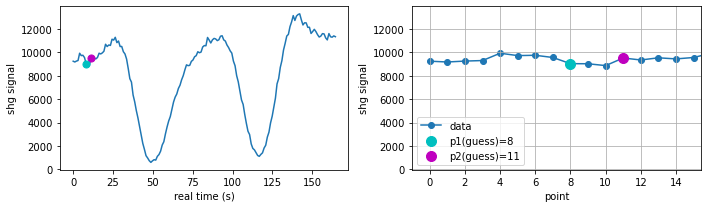

In [31]:
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(time_s, data,zorder = 1)
ax1.scatter(time_s[point2], data[point2], color = 'm', s=50, zorder = 2)
ax1.scatter(time_s[point1], data[point1], color = 'c', s=50, zorder = 3)
ax1.set_xlabel('real time (s)')
ax1.set_ylabel('shg signal')

ax2 = fig.add_subplot(1,2,2)

ax2.plot(time_i, data, '-o', zorder = 1, label = 'data')
ax2.scatter(time_i[point1], data[point1], color = 'c', s=100, zorder = 2, label=f'p1(guess)={point1}')
ax2.scatter(time_i[point2], data[point2], color = 'm', s=100, zorder = 3, label=f'p2(guess)={point2}')

ax2.grid()
ax2.legend()
ax2.set_xlim(-1,point2*1.4)
#ax2.set_ylim(0,5200)
ax2.set_xlabel('point')
ax2.set_ylabel('shg signal')

plt.tight_layout()
plt.show()

## ジャンプの位置を自分で入力する

In [32]:
point1 = 4
point2 = 7

angle_theta = speed_degs * (time_s - time_s[(point2 * 2 - point1 -1)])
print(f'exposure time is {speed_degs * (time_s[point2] - time_s[point1])/4:.3g} sec.')
print(f'waiting time is {speed_degs * (time_s[point2] - time_s[point1]):.3g} sec')

exposure time is 1.9 sec.
waiting time is 7.61 sec


## 使える範囲だけを抽出

In [33]:
angle_theta_export = angle_theta[(angle_theta >=0) & (angle_theta <totalangle_theta)]
data_export = data[(angle_theta >=0) & (angle_theta <totalangle_theta)]
angle_rad_export = 2 * np.pi * angle_theta_export /360

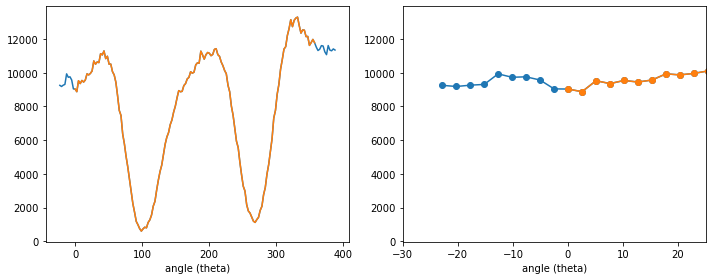

In [34]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(angle_theta, data)
ax1.plot(angle_theta_export, data_export)
ax1.set_xlabel('angle (theta)')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(angle_theta, data, '-o')
ax2.plot(angle_theta_export, data_export, '-o')
ax2.set_xlim(-30,25)
#ax2.set_ylim(0,5200)
ax2.set_xlabel('angle (theta)')

plt.tight_layout()
plt.show()

## 極座標プロット

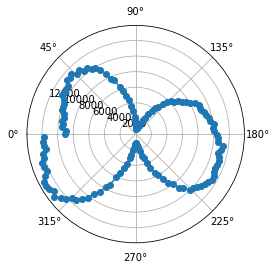

In [61]:
filename = 'shg.jpg'
outfile = os.path.join(dirname, filename)

fig=plt.figure()
ax = plt.subplot(111, projection="polar")
#ax.set_theta_direction(1), -1
plt.plot(angle_rad_export, data_export, '-o')
#ax.set_rmax(14000.0)
ax.set_theta_direction('clockwise')
ax.set_theta_zero_location("W")
#ax.set_rmin(0)
plt.show()
fig.savefig(outfile, dpi=300)

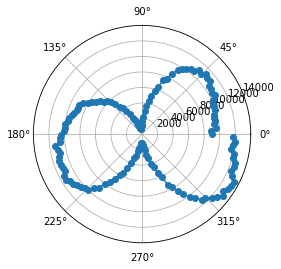

In [60]:
filename = 'shg.jpg'
outfile = os.path.join(dirname, filename)

fig=plt.figure()
ax = plt.subplot(111, projection="polar")
#ax.set_theta_direction(1), -1
plt.plot(angle_rad_export, data_export, '-o')
ax.set_rmax(14000.0)
ax.set_theta_direction('anticlockwise')
#ax.set_rmin(0)
plt.show()
fig.savefig(outfile, dpi=300)

## データの保存

In [36]:
df_analized = pd.DataFrame(angle_theta_export)
df_analized.columns = ['angle_theta']
df_analized['data'] = pd.DataFrame(data_export)

filename ='analyzed.csv'
outfile = os.path.join(dirname, filename)
df_analized.to_csv(outfile, index = False)
df_analized.head(3)

,angle_theta,data
0,0.000,9033.073433
1,2.545,8875.798539
2,5.090,9525.627067
